## Passionate Investors and Cryptopunks. ERC20 Analysis

In [1]:
import pandas as pd
from math import log10

from config import PROJECT_ID, INITIAL_TS, SNAPSHOT_TS, \
    ERC20_ANALYSIS_DATASET_NAME, ERC20_BALANCES_TABLE_NAME, ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    ERC20_TOKEN_METADATA_TABLE_NAME, STABLECOINS_LOVERS_TABLE_NAME, INVESTORS_AUDIENCE, CRYPTOPUNKS_AUDIENCE
from src.utils_bigquery import drop_table, create_table, create_table_from_df, get_df
from src.utils_charts import grade_boundaries_analysis

DROP_TABLES = True
CREATE_TABLES = True

### Distribution Rule. Passionate Investors

<table style="text-align: left">
    <thead style="text-align: center">
        <tr>
            <th rowspan=2></th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> Number of tokens >= 2 and ERC20 balance </td>
            <td> > 0.01 ETH </td>
            <td> > 6 ETH </td>
            <td> > 76 ETH </td>
        </tr>
    </tbody>
</table>

### Distribution Rule. Cryptopunks

<table style="text-align: left">
    <thead style="text-align: center">
        <tr>
            <th rowspan=2></th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> Owners of the Selected tokens </td>
            <td> - </td>
            <td> - </td>
            <td> here </td>
        </tr>
    </tbody>
</table>

In [2]:
investors_min_number_of_tokens = 2
investors_boundary_erc20_balance = [0.01, 6, 76]

investors_erc20_tokens_dict = {
    # name:   [address,                                      ETH price,  decimals]
    'YFI':    ['0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e', 17.2,      18],
    'FTM':    ['0x4e15361fd6b4bb609fa63c81a2be19d873717870', 0.000256,   18],
    'AMPL':   ['0xd46ba6d942050d489dbd938a2c909a5d5039a161', 0.000400,   9],
    'renBTC': ['0xeb4c2781e4eba804ce9a9803c67d0893436bb27d', 20.2,   8],
    'OCEAN':  ['0x967da4048cd07ab37855c090aaf366e4ce1b9f48', 0.000480,   18],
    'RPL':    ['0xb4efd85c19999d84251304bda99e90b92300bd93', 0.00669,   18],
    'UNI':    ['0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 0.0143,    18],
    'KEEP3R': ['0x1ceb5cb57c4d4e2b2433641b95dd330a33185a44', 0.108,     18],
    'GST2':   ['0x0000000000b3f879cb30fe243b4dfee438691c04', 0.0493,      2],
    'CHI':    ['0x0000000000004946c0e9f43f4dee607b0ef1fa1c', 0.00101,    0],
    'MLN':    ['0xec67005c4e498ec7f55e092bd1d35cbc47c91892', 0.0414,    18],
    'AAVE':   ['0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9', 0.162,     18],
    'GNT':    ['0xa74476443119A942dE498590Fe1f2454d7D4aC0d', 0.0002534,  18], #?
    'GLM':    ['0x7dd9c5cba05e151c895fde1cf355c9a1d5da6429', 0.000162,  18],
    'ZRX':    ['0xe41d2489571d322189246dafa5ebde1f4699f498', 0.000639,  18],
    'SNX':    ['0xc011a73ee8576fb46f5e1c5751ca3b9fe0af2a6f', 0.00635,    18],
    'SUSHI':  ['0x6b3595068778dd592e39a122f4f5a5cf09c90fe2', 0.00513,   18],
    'COMP':   ['0xc00e94cb662c3520282e6f5717214004a7f26888', 0.261,     18],
    'BAL':    ['0xba100000625a3754423978a60c9317c58a424e3d', 0.0218,    18],
    'GRT':    ['0xc944e90c64b2c07662a292be6244bdf05cda44a7', 0.000583,   18],
    'MKR':    ['0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2', 1.57,     18],
    'CRV':    ['0xd533a949740bb3306d119cc777fa900ba034cd52', 0.00115,   18],
    'LPT':    ['0x58b6a8a3302369daec383334672404ee733ab239', 0.0121,   18],
    'REL':    ['0xb6c4267c4877bb0d6b1685cfd85b0fbe82f105ec', 0.00122,  18],
    'ANT':    ['0xa117000000f279d81a1d3cc75430faa017fa5a2e', 0.00348,   18],
    'GEN':    ['0x543ff227f64aa17ea132bf9886cab5db55dcaddf', 0.0000915, 18],
    'PNK':    ['0x93ed3fbe21207ec2e8f2d3c3de6e058cb73bc04d', 0.0000682, 18],
    'REP':    ['0x221657776846890989a759ba2973e427dff5c9bb', 0.0142,     18],
    'SNT':    ['0x744d70fdbe2ba4cf95131626614a1763df805b9e', 0.0000629, 18],
    '2KEY':   ['0xE48972fCd82a274411c01834e2f031D4377Fa2c0', 0.0000241, 18],
    'NU':     ['0x4fE83213D56308330EC302a8BD641f1d0113A4Cc', 0.000184,  18],
    'MANA':   ['0x0f5d2fb29fb7d3cfee444a200298f468908cc942', 0.000505,  18],
    'TORN':   ['0x77777feddddffc19ff86db637967013e6c6a116c', 0.0412,    18],
    'XRT':    ['0x7de91b204c1c737bcee6f000aaa6569cf7061cb7', 0.0152,     9]}

cryptopunks_erc20_tokens_dict = {
    # name:   [address,                                      ETH price,  decimals]
    'FOAM':   ['0x4946fcea7c692606e8908002e55a582af44ac121', 0.0000278, 18],
    'GOLD':   ['0x150b0b96933b75ce27af8b92441f8fb683bf9739', 0.00000243, 18]}

# USD Based Stablecoins with Marketcap more than 100K ETH
stablecoins_erc20_tokens_dict = {
    # name:           [address,                                      ETH price,  decimals]
    'Tether':         ['0xdac17f958d2ee523a2206206994597c13d831ec7', 0.000364,  6],
    'USD Coin':       ['0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', 0.000364,  6],
    'Binance USD':    ['0x4fabb145d64652a948d72533023f6e7a623c7c53', 0.000364, 18],
    'DAI':            ['0x6b175474e89094c44da98b954eedeac495271d0f', 0.000364, 18],
    'Fei Protocol':   ['0x956f47f50a910163d8bf957cf5846d573e7f87ca', 0.000364, 18],
    'TerraUSD':       ['0xa47c8bf37f92abed4a126bda807a7b7498661acd', 0.000364, 18],
    'Liquity USD':    ['0x5f98805a4e8be255a32880fdec7f6728c6568ba0', 0.000364, 18],
    'Paxos Standard': ['0x8e870d67f660d95d5be530380d0ec0bd388289e1', 0.000364, 18],
    'TrueUSD':        ['0x0000000000085d4780b73119b644ae5ecd22b376', 0.000364, 18],
    'HUSD':           ['0xdf574c24545e5ffecb9a659c229253d4111d87e1', 0.000364,  8],
    'Neutrino USD':   ['0x674c6ad92fd080e4004b2312b45f796a192d27a0', 0.000364, 18],
    'sUSD':           ['0x57ab1ec28d129707052df4df418d58a2d46d5f51', 0.000364, 18]
}

### Set Token Data

In [3]:
investors_erc20_tokens_dict = {k: [v[0].lower(), v[1], v[2]] for k, v in investors_erc20_tokens_dict.items()}
investors_erc20_tokens_addresses_tuple = tuple([item[0] for item in investors_erc20_tokens_dict.values()])
investors_erc20_tokens_df = pd.DataFrame(investors_erc20_tokens_dict.values(),
                                         index=investors_erc20_tokens_dict.keys(),
                                         columns=['address', 'eth_price', 'decimals']).reset_index()

cryptopunks_erc20_tokens_dict = {k: [v[0].lower(), v[1], v[2]] for k, v in cryptopunks_erc20_tokens_dict.items()}
cryptopunks_erc20_tokens_addresses_tuple = tuple([item[0] for item in cryptopunks_erc20_tokens_dict.values()])
cryptopunks_erc20_tokens_df = pd.DataFrame(cryptopunks_erc20_tokens_dict.values(),
                                           index=cryptopunks_erc20_tokens_dict.keys(),
                                           columns=['address', 'eth_price', 'decimals']).reset_index()

stablecoins_erc20_tokens_dict = {k: [v[0].lower(), v[1], v[2]] for k, v in stablecoins_erc20_tokens_dict.items()}
stablecoins_erc20_tokens_addresses_tuple = tuple([item[0] for item in stablecoins_erc20_tokens_dict.values()])
stablecoins_erc20_tokens_df = pd.DataFrame(stablecoins_erc20_tokens_dict.values(),
                                           index=stablecoins_erc20_tokens_dict.keys(),
                                           columns=['address', 'eth_price', 'decimals']).reset_index()

erc20_tokens_addresses_tuple = investors_erc20_tokens_addresses_tuple + \
                               cryptopunks_erc20_tokens_addresses_tuple + \
                               stablecoins_erc20_tokens_addresses_tuple
erc20_tokens_df = investors_erc20_tokens_df\
                      .append(cryptopunks_erc20_tokens_df)\
                      .append(stablecoins_erc20_tokens_df)

### Create Token Metadata Table

In [4]:
if CREATE_TABLES:
    r = create_table_from_df(source_df=erc20_tokens_df,
                             table_name=ERC20_TOKEN_METADATA_TABLE_NAME,
                             dataset_name=ERC20_ANALYSIS_DATASET_NAME,
                             drop_existing_table=DROP_TABLES)
elif DROP_TABLES:
    drop_table(table_name=ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME,
               dataset_name=ERC20_ANALYSIS_DATASET_NAME)

### Get Balances

In [5]:
query_1 = f'''
        WITH token_transfers AS (
                SELECT
                    token_address,
                    address,
                    sum(value) as balance
                FROM (SELECT
                            token_address,
                            from_address as address,
                            - safe_cast(value as numeric) as value
                        FROM `bigquery-public-data.crypto_ethereum.token_transfers`
                        WHERE token_address IN {erc20_tokens_addresses_tuple}
                          AND from_address NOT IN ('0x0000000000000000000000000000000000000000')
                          AND block_timestamp >= '{INITIAL_TS}'
                          AND block_timestamp <= '{SNAPSHOT_TS}'

                        UNION ALL

                        SELECT
                            token_address,
                            to_address as address,
                            safe_cast(value as numeric) as value
                        FROM `bigquery-public-data.crypto_ethereum.token_transfers`
                        WHERE token_address IN {erc20_tokens_addresses_tuple}
                          AND to_address NOT IN ('0x0000000000000000000000000000000000000000')
                          AND block_timestamp >= '{INITIAL_TS}'
                          AND block_timestamp <= '{SNAPSHOT_TS}'
                        )
                GROUP BY token_address, address
                HAVING balance > 0
        )
        SELECT
            token_address,
            token_transfers.address as address,
            balance,
            token_metadata.eth_price as eth_price,
            token_metadata.decimals as decimals,
            balance * token_metadata.eth_price / pow(10, token_metadata.decimals) as eth_balance
        FROM token_transfers
        LEFT JOIN `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_TOKEN_METADATA_TABLE_NAME}` as token_metadata
        ON token_transfers.token_address = token_metadata.address
'''

if DROP_TABLES:
    drop_table(table_name=ERC20_BALANCES_TABLE_NAME,
               dataset_name=ERC20_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_1,
                 table_name=ERC20_BALANCES_TABLE_NAME,
                 dataset_name=ERC20_ANALYSIS_DATASET_NAME)

Table erc20_analysis:erc20_balances has been deleted.
Table erc20_analysis:erc20_balances has been created and filled 8639629 rows.


## Get Stablecoin Lovers

In [6]:
query_2 = f'''
SELECT
    address,
    sum(non_stablecoin_balance) as sum_non_stablecoin_balance,
    sum(stablecoin_balance) as sum_stablecoin_balance
FROM (
    SELECT
        address,
        if(token_address IN {investors_erc20_tokens_addresses_tuple + cryptopunks_erc20_tokens_addresses_tuple}, eth_balance, 0) as non_stablecoin_balance,
        if(token_address IN {stablecoins_erc20_tokens_addresses_tuple}, eth_balance, 0) as stablecoin_balance
    FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_BALANCES_TABLE_NAME}`)
GROUP BY address
HAVING sum_stablecoin_balance > sum_non_stablecoin_balance
   AND sum_stablecoin_balance > 0.1
'''

if DROP_TABLES:
    drop_table(table_name=STABLECOINS_LOVERS_TABLE_NAME,
               dataset_name=ERC20_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_2,
                 table_name=STABLECOINS_LOVERS_TABLE_NAME,
                 dataset_name=ERC20_ANALYSIS_DATASET_NAME)

Table erc20_analysis:stablecoins_lovers has been deleted.
Table erc20_analysis:stablecoins_lovers has been created and filled 878812 rows.


### Create Distribution Table

In [6]:
query_3 = f'''
    SELECT
        '{INVESTORS_AUDIENCE}' as audience,
        'ERC20 Balance' as segment,
        address,
        CASE
            WHEN sum_eth_balance > {investors_boundary_erc20_balance[2]} THEN 3
            WHEN sum_eth_balance > {investors_boundary_erc20_balance[1]} THEN 2
            WHEN sum_eth_balance > {investors_boundary_erc20_balance[0]} THEN 1
        END
        AS grade,
        sum_eth_balance,
        number_of_tokens
    FROM (
        SELECT
            address,
            count(distinct token_address) as number_of_tokens,
            sum(eth_balance) as sum_eth_balance
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_BALANCES_TABLE_NAME}`
        WHERE balance > 0
          AND token_address IN {investors_erc20_tokens_addresses_tuple}
        GROUP BY address)
    WHERE number_of_tokens >= {investors_min_number_of_tokens}

    UNION ALL

    SELECT
        '{CRYPTOPUNKS_AUDIENCE}' as audience,
        'Owners of the Selected ERC20 Tokens' as segment,
        address,
        3 AS grade,
        sum_eth_balance,
        number_of_tokens
    FROM (
        SELECT
            address,
            count(distinct token_address) as number_of_tokens,
            sum(eth_balance) as sum_eth_balance
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_BALANCES_TABLE_NAME}`
        WHERE balance > 0
          AND token_address IN {cryptopunks_erc20_tokens_addresses_tuple}
        GROUP BY address)
'''

if DROP_TABLES:
    drop_table(table_name=ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME,
               dataset_name=ERC20_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_3,
                 table_name=ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME,
                 dataset_name=ERC20_ANALYSIS_DATASET_NAME)

Table erc20_analysis:erc20_analysis_distribution has been deleted.
Table erc20_analysis:erc20_analysis_distribution has been created and filled 244902 rows.


### Analysis of Grade Boundaries. ERC20 balance

In [7]:
query_4 = f'''
    SELECT
        if(round(sum_eth_balance, 1) < 0.1, 0.05, round(sum_eth_balance, 1)) as erc20_balance_class,
        count(address) as number_of_addresses
    FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
    WHERE number_of_tokens >= {investors_min_number_of_tokens}
      AND audience = '{INVESTORS_AUDIENCE}'
    GROUP BY erc20_balance_class
    HAVING erc20_balance_class > 0
'''
distribution_by_erc20_balance_df = get_df(query_4)

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,0.01 < ERC20 Balance <= 6.0,217447,90.3
2,6.0 < ERC20 Balance <= 76.0,20960,8.7
3,76.0 < ERC20 Balance,2410,1.0


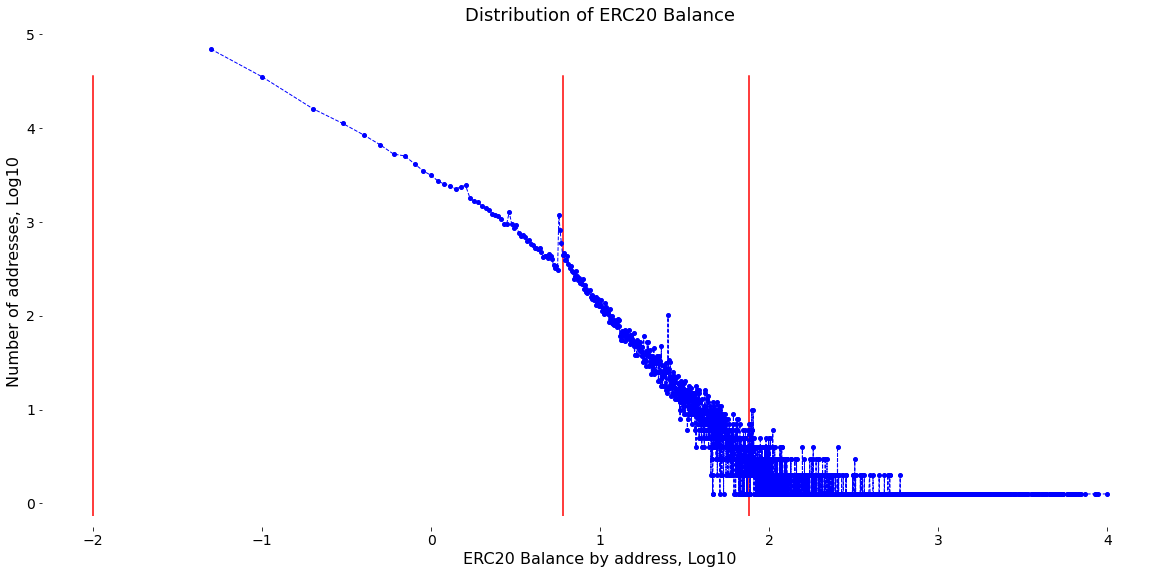

[0.01, 6.0, 76.0]

In [8]:
grade_boundaries_analysis(
    distribution_df=distribution_by_erc20_balance_df,
    value_column = 'erc20_balance_class',
    value_chart_label = 'ERC20 Balance by address, Log10',
    value_name = 'ERC20 Balance',
    value_transform_func=lambda x: log10(x),
    chart_title = 'Distribution of ERC20 Balance',
    initial_boundary=0.01,
    max_show_value=10000,
    level_line_shift=0)